In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime
from scipy import signal
from pandasql import sqldf
import seaborn as sns
import pingouin as pg
from collections import defaultdict
import glob

# Treadmill data analysis
Quentin Decultot, JJ Aucouturier, 2021

## Step signal processing

The goal of this section is to segment step data corresponding to each trial/note, and to extract features from each step, resulting in a dataframe in the form of: 
<table>
<thead>
  <tr>
    <th>subj</th>
    <th>trial_id</th>
    <th>note</th>
    <th>step_feature</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td>1</td>
    <td>1</td>
    <td>A4</td>
    <td>2.3</td>
  </tr>
  <tr>
    <td>1</td>
    <td>2</td>
    <td>Bb3</td>
    <td>0.6</td>
  </tr>
  <tr>
    <td>1</td>
    <td>...</td>
    <td></td>
    <td></td>
  </tr>
  <tr>
    <td>1</td>
    <td>1500</td>
    <td>C#5</td>
    <td>1.8</td>
  </tr>
</tbody>
</table>

### Preprocessing

#### Normalize by weight

In [3]:
def extract_weight(data):
    
    # find reset index, corresponding to change of foot
    reset_index = data[np.append([False],(np.diff(data.time)<0))].index[0]
    
    # tag foot
    data.loc[:reset_index,'foot']='left'
    data.loc[reset_index:,'foot']='right'
    
    # select median as mean weight per foot
    mean_weights = data.groupby(['foot'])[['z_left','z_right']].median().reset_index()
    min_weights = data.groupby(['foot'])[['z_left','z_right']].min().reset_index()
    
    left_weight = float(mean_weights[mean_weights.foot=='left'].z_left)
    left_zero = float(min_weights[min_weights.foot=='right'].z_left) # absolute minimum of left treadmill when all weight in on right foot
    
    right_weight = float(mean_weights[mean_weights.foot=='right'].z_right)
    right_zero = float(min_weights[min_weights.foot=='left'].z_right)# absolute minimum of right treadmill when all weight in on left foot
    
    return left_weight,left_zero,right_weight,right_zero

weight_data='treadmill_1_21_06_15_10_04_weight.csv'
cols = ['time','x_left','y_left','z_left','x_right','y_right','z_right']
weight_data = pd.read_csv('data/'+weight_data)
weight_data[cols] = weight_data[cols].apply(pd.to_numeric)
    
left_weight,left_zero,right_weight,right_zero = extract_weight(weight_data)
print('left_weight: %f, left_zero: %f'%(left_weight,left_zero))
print('right_weight: %f, right_zero: %f'%(right_weight,right_zero))
       

left_weight: 1.479141, left_zero: -1.495401
right_weight: 2.710569, right_zero: -0.030261


In [5]:
def normalize_by_weight(df,left_weight,left_zero,right_weight,right_zero):
    
    norm_df = df.copy()
    
    norm_df['z_left'] = (norm_df.z_left - left_zero)/(left_weight-left_zero)
    norm_df['z_right'] = (norm_df.z_right - right_zero)/(right_weight-right_zero)
    
    return norm_df

treadmill_data='treadmill_participant_1_order_1_21_06_15_10_04_data.csv'
cols = ['time','x_left','y_left','z_left','x_right','y_right','z_right']
treadmill_data = pd.read_csv('data/'+treadmill_data)
treadmill_data[cols] = treadmill_data[cols].apply(pd.to_numeric)

weight_data='treadmill_1_21_06_15_10_04_weight.csv'
weight_data = pd.read_csv('data/'+weight_data)
weight_data[cols] = weight_data[cols].apply(pd.to_numeric)
left_weight,left_zero,right_weight,right_zero = extract_weight(weight_data)
print('left_weight: %f, left_zero: %f'%(left_weight,left_zero))
print('right_weight: %f, right_zero: %f'%(right_weight,right_zero))

norm_df = normalize_by_weight(treadmill_data,left_weight,left_zero,right_weight,right_zero)

    

left_weight: 1.479141, left_zero: -1.495401
right_weight: 2.710569, right_zero: -0.030261


#### Resample

['time', 'x_left', 'y_left', 'z_left', 'x_right', 'y_right', 'z_right', 'participant', 'config_file', 'order', 'condition_name']
['x_left', 'y_left', 'z_left', 'x_right', 'y_right', 'z_right', 'time', 'participant', 'config_file', 'order', 'condition_name']


Text(0.5, 1.0, '100Hz')

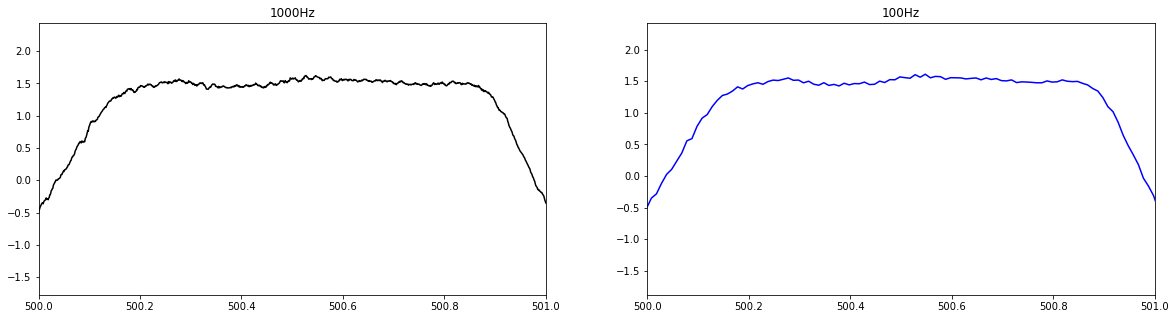

In [7]:
def resample_all_cols(df, sr=1000, new_sr=100, time_col='time'): 
    # resample all data columns to new_sr
    # not in place (copies df to new df)
    
    # list data columns 
    data_cols = ['x_left','y_left','z_left','x_right','y_right','z_right']
    non_data_cols = list(df)
    for data_col in data_cols: 
        non_data_cols.remove(data_col) 
    non_data_cols.remove(time_col)
    
    # resample data cols
    resampled_df = pd.DataFrame()
    for data_col in data_cols: 
        data = np.array(df[data_col])
        time = np.array(df[time_col])
        (new_data,new_time) = signal.resample(data,
                                t=time,
                                num = int((len(data)/sr)*new_sr))
        resampled_df[data_col] = new_data
    
    # add resampled time    
    resampled_df['time'] = new_time
    
    # add non_data columns
    resampled_df[non_data_cols] = df[non_data_cols]
    
    return resampled_df

# test
treadmill_data='treadmill_participant_1_order_1_21_06_15_10_04_data.csv'
cols = ['time','x_left','y_left','z_left','x_right','y_right','z_right']
treadmill_data = pd.read_csv('data/'+treadmill_data)
treadmill_data[cols] = treadmill_data[cols].apply(pd.to_numeric)
sr=1000
print(list(treadmill_data))

rs_data = resample_all_cols(treadmill_data)

print(list(rs_data))


# plot original vs resampled 
x = np.array(treadmill_data['z_left'])
t = np.array(treadmill_data['time'])
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1,2,1)
plt.plot(t/1000,x,'k')
plt.xlim([500, 501])
plt.title('%dHz'%sr)
ax = fig.add_subplot(1,2,2)
x = np.array(rs_data['z_left'])
t = np.array(rs_data['time'])
plt.plot(t/1000,x,'b')
plt.xlim([500, 501])
plt.title('%dHz'%100)

#### Detrend

['x_left', 'y_left', 'z_left', 'x_right', 'y_right', 'z_right', 'time', 'participant', 'config_file', 'order', 'condition_name']


(-2.1, 2.0)

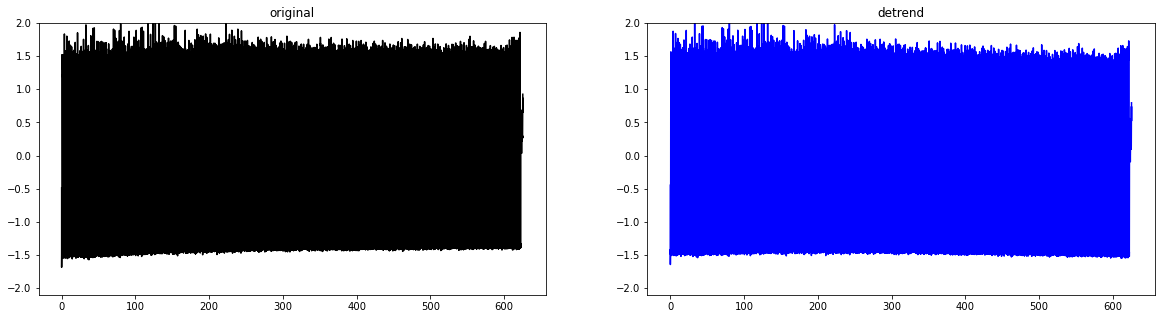

In [9]:
def detrend_all_cols(df):
    # remove linear trend in data
    
    # list data columns (neither index nor time)
    data_cols =  ['x_left','y_left','z_left','x_right','y_right','z_right']
    non_data_cols = list(df)
    for data_col in data_cols: 
        non_data_cols.remove(data_col) 
    
    detrend_df = pd.DataFrame()
    for data_col in data_cols: 
        detrend_df[data_col]=signal.detrend(np.array(df[data_col]),
                                             type='linear')
        # remove offset, to keep in the same range as beginning of series
        detrend_df[data_col]=detrend_df[data_col]-detrend_df[data_col].quantile(.01)+ df[data_col].quantile(.01)
    
    # add non_data columns
    detrend_df[non_data_cols] = df[non_data_cols]
    
    return detrend_df

# test
treadmill_data='treadmill_participant_1_order_1_21_06_15_10_04_data.csv'
cols = ['time','x_left','y_left','z_left','x_right','y_right','z_right']
treadmill_data = pd.read_csv('data/'+treadmill_data)
treadmill_data[cols] = treadmill_data[cols].apply(pd.to_numeric)

rs_data = resample_all_cols(treadmill_data)
d_data = detrend_all_cols(rs_data)
print(list(d_data))

x = np.array(rs_data['z_left'])
t = np.array(rs_data['time'])
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1,2,1)
plt.plot(t/1000,x,'k')
plt.title('original')
plt.ylim([-2.1,2.0])
ax = fig.add_subplot(1,2,2)
x = np.array(d_data['z_left'])
t = np.array(d_data['time'])
plt.plot(t/1000,x,'b')
plt.title('detrend')
plt.ylim([-2.1,2.0])    

### Segmentation

The goal of this section is to segment step data corresponding to each trial/note, downsample it to a suitable sampling rate, and store it in a dataframe.  
<table>
<thead>
  <tr>
    <th>subj</th>
    <th>trial_id</th>
    <th>note</th>
    <th>step_data_left_x</th>
    <th>step_data_left_y</th>
    <th>...</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td>1</td>
    <td>1</td>
    <td>A4</td>
    <td>[2.3,3.5,...,4.8]</td>
    <td>[-3.2,-0.8,...]</td>
    <td>...</td>
  </tr>
</tbody>
</table>

(604.0, 606.0)

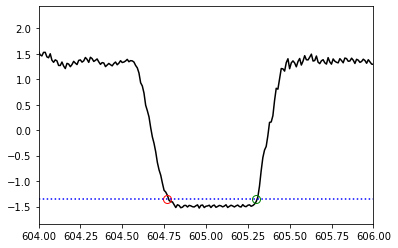

In [12]:
# find start and stop times for each step in time series x
# minduration in sec.
def segment_steps(times,x, min_duration):
    start_times = []
    end_times = []
    
    # adapt threshold to min + a percent of (range of x)
    x_min = np.percentile(x,1) 
    x_max = np.percentile(x,99)
    percent_range = 0.05
    threshold = x_min + (x_max-x_min)*percent_range
    
    # detect up and down crossings     
    mask = np.diff(1*(x > threshold)) # 1 if crosses threshold up, -1 if crosses down
    start_times = times[:-1][mask>0] 
    end_times = times[:-1][mask<0] 
    
    # drop potential endings that occur before first start
    end_times = [end_time for end_time in list(end_times) if end_time > list(start_times)[0]]
    # drop potential starts that occur after the last ending
    start_times = [start_time for start_time in list(start_times) if start_time < list(end_times)[-1]]
        
    # eliminate false alarms (ie. consecutive starts or stops within a short time window, ex. 0.1s)
    start_times, end_times = zip(*[(start_time,end_time) for start_time,end_time in zip(start_times,end_times) if (end_time-start_time) > (min_duration*1000)])
    
    return start_times, end_times, threshold

#test    
treadmill_data='treadmill_participant_1_order_1_21_06_15_10_04_data.csv'
cols = ['time','x_left','y_left','z_left','x_right','y_right','z_right']
treadmill_data = pd.read_csv('data/'+treadmill_data)
treadmill_data[cols] = treadmill_data[cols].apply(pd.to_numeric)

rs_step_data = resample_all_cols(treadmill_data,sr,100)
de_step_data = detrend_all_cols(rs_step_data)

times = de_step_data.time
x = de_step_data.z_left
start_times, end_times, threshold = segment_steps(times,x, 0.1)
plt.plot(times/1000, x, 'k')
plt.plot(np.array(start_times)/1000,[threshold]*len(start_times), 'go', markersize=8, markerfacecolor='None')
plt.plot(np.array(end_times)/1000,[threshold]*len(end_times), 'ro', markersize=8, markerfacecolor='None')
plt.plot([times.min()/1000,times.max()/1000],[threshold,threshold],'b:')
plt.xlim([604,606])

#### List individual steps in a Dataframe

In [13]:
def convert_to_steps(treadmill_data, min_duration=0.1):
# segment left steps from z_left, and right steps from z_right
# and list all steps (tagged as left/right) in a new dataframe

    # list data columns (neither index nor time)
    data_cols =  ['x_left','y_left','z_left','x_right','y_right','z_right']
    non_data_cols = list(treadmill_data)
    for data_col in data_cols: 
        non_data_cols.remove(data_col)
    non_data_cols.remove('time')
        
    # segment steps from each foot
    foots = ['left','right']
    foot_features = ['z_left','z_right']
    dimensions = ['x','y','z']
    
    # grow dataframe of steps 
    dataframe_cols = defaultdict(list) # dictionary of {col: list of values}
    for (foot,foot_feature) in zip(foots, foot_features): 
        
        # extract start and end times for current foot, using foot_feature
        start_times, end_times, threshold = segment_steps(treadmill_data.time,
                                                          treadmill_data[foot_feature],
                                                          min_duration=min_duration)
        
        # for each step, extract treadmill data along all dimensions (x,y,z)
        for start_time,end_time in zip(start_times,end_times): 
 
            for dimension in dimensions: 
                feature = '%s_%s'%(dimension,foot) # ex. x_left 
                step_data_for_dimension = list(treadmill_data[(treadmill_data.time >=start_time)&(treadmill_data.time <end_time)][feature])
                dataframe_cols[dimension].append(step_data_for_dimension)
            
            dataframe_cols['start'].append(start_time/1000) # time in secs
            dataframe_cols['end'].append(end_time/1000) # time in secs
            dataframe_cols['foot'].append(foot)
            
    steps = pd.DataFrame(dataframe_cols)
    
    steps[non_data_cols] = treadmill_data[non_data_cols]
    
    return steps

treadmill_data='treadmill_participant_1_order_1_21_06_15_10_04_data.csv'
cols = ['time','x_left','y_left','z_left','x_right','y_right','z_right']
treadmill_data = pd.read_csv('data/'+treadmill_data)
treadmill_data[cols] = treadmill_data[cols].apply(pd.to_numeric)
rs_treadmill_data = resample_all_cols(treadmill_data)
de_treadmill_data = detrend_all_cols(rs_treadmill_data)
steps = convert_to_steps(de_treadmill_data)
list(steps)

['x',
 'y',
 'z',
 'start',
 'end',
 'foot',
 'participant',
 'config_file',
 'order',
 'condition_name']

#### Merge with sound events

In [14]:
def merge_step_data_with_sounds(step_data,sound_data): 
# take df of individual steps (with start and end_times, and treadmill data as lists) 
# and join on sound events where sound.time is in [start,end]
# uses a sql join (because pandas doesn't join on >= and <=), and for this convert list columns to strings

    # convert data columns to str for the SQL operation
    dimensions = ['x','y','z']
    step_data[dimensions] = step_data[dimensions].applymap(str)
    
    sound_data['sound_id']= sound_data.index
    
    query = """
    SELECT step_data.*, sound_data.*
    FROM sound_data INNER JOIN step_data
    ON (sound_data.time >= step_data.start AND sound_data.time < step_data.end)
    ORDER BY sound_data.time
    """
    mixed_data = sqldf(query, locals())
    
    # convert back to list of float
    for dimension in dimensions: 
        mixed_data[dimension]=mixed_data[dimension].apply(lambda row: [float(d) for d in row[1:-1].split(',')]  )
    
    # remove duplicated (categorical) columns
    mixed_data = mixed_data.loc[:,~mixed_data.columns.duplicated()]
    
    return mixed_data

treadmill_data='treadmill_participant_1_order_1_21_06_15_10_04_data.csv'
cols = ['time','x_left','y_left','z_left','x_right','y_right','z_right']
treadmill_data = pd.read_csv('data/'+treadmill_data)
treadmill_data[cols] = treadmill_data[cols].apply(pd.to_numeric)
rs_treadmill_data = resample_all_cols(treadmill_data)
de_treadmill_data = detrend_all_cols(rs_treadmill_data)
step_data = convert_to_steps(de_treadmill_data)

sound_data='treadmill_participant_1_order_1_21_06_15_10_04_sound.csv'
sound_data = pd.read_csv('data/'+sound_data)
sound_data.pitch = sound_data.pitch.apply(pd.to_numeric)

merged_data = merge_step_data_with_sounds(step_data,sound_data)



#### Delete duplicates

Some steps are attributed to two or more sound events, e.g. when the next sound starts before the previous step ends. Here, we simply drop (step,sound event) pairs for sound_id duplicates. A more advanced method would e.g. attribute the sound event to the step which has the least distance between sound.time and step.start. 

In [15]:
treadmill_data='treadmill_participant_1_order_1_21_06_15_10_04_data.csv'
cols = ['time','x_left','y_left','z_left','x_right','y_right','z_right']
treadmill_data = pd.read_csv('data/'+treadmill_data)
treadmill_data[cols] = treadmill_data[cols].apply(pd.to_numeric)
rs_treadmill_data = resample_all_cols(treadmill_data)
de_treadmill_data = detrend_all_cols(rs_treadmill_data)
step_data = convert_to_steps(de_treadmill_data)

sound_data='treadmill_participant_1_order_1_21_06_15_10_04_sound.csv'
sound_data = pd.read_csv('data/'+sound_data)
sound_data.pitch = sound_data.pitch.apply(pd.to_numeric)

merged_data = merge_step_data_with_sounds(step_data,sound_data)

merged_data.drop_duplicates(subset ="sound_id", keep = False, inplace=True)

### Step feature extraction

The goal of this section is to extract features from each step data.  
<table>
<thead>
  <tr>
    <th>subj</th>
    <th>trial_id</th>
    <th>note</th>
    <th>step_data_left_x</th>
    <th>max_amplitude_left_x</th>
    <th>duration_left_x</th>
    <th>step_data_left_y</th>
    <th>max_amplitude_left_y</th>
    <th>...</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td>1</td>
    <td>1</td>
    <td>A4</td>
    <td>[2.3,3.5,...,4.8]</td>
    <td>6.8</td>
    <td>1.3</td>
    <td>[-3.2,-0.8,...]</td>
    <td>...</td>
  </tr>
</tbody>
</table>

#### Zscore step data

In [16]:
def zscore_step_data(step_data): 

    for foot in ['left','right']: 
        
        dimensions = ['x','y','z']
        for dimension in dimensions:
        
            # concatenate all step data in current dimension to compute mean and std
            data_in_dimension = []
            for index, row in step_data[step_data.foot==foot].iterrows():
                data_in_dimension += row[dimension]
            mean_dimension = np.mean(data_in_dimension)
            std_dimension = np.std(data_in_dimension)
        
            #print('%s-%s: M=%.2f,SD=%.2f'%(foot.upper(),dimension,mean_dimension, std_dimension))
        
            # normalize values
            step_data.loc[step_data.foot==foot,dimension+'_zscore'] = step_data[step_data.foot==foot][dimension].apply(lambda row: (row - mean_dimension)/std_dimension)
    
    return step_data

treadmill_data='treadmill_participant_1_order_1_21_06_15_10_04_data.csv'
cols = ['time','x_left','y_left','z_left','x_right','y_right','z_right']
treadmill_data = pd.read_csv('data/'+treadmill_data)
treadmill_data[cols] = treadmill_data[cols].apply(pd.to_numeric)
rs_treadmill_data = resample_all_cols(treadmill_data)
de_treadmill_data = detrend_all_cols(rs_treadmill_data)
step_data = convert_to_steps(de_treadmill_data)

sound_data='treadmill_participant_1_order_1_21_06_15_10_04_sound.csv'
sound_data = pd.read_csv('data/'+sound_data)
sound_data.pitch = sound_data.pitch.apply(pd.to_numeric)

merged_data = merge_step_data_with_sounds(step_data,sound_data)
merged_data = zscore_step_data(merged_data)



#### Extract step duration

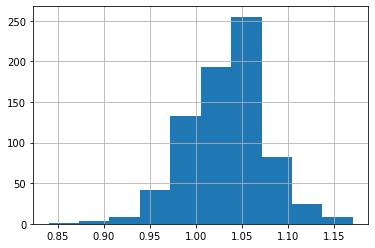

In [17]:
def extract_step_duration(step_data): 

    step_data['step_duration'] = step_data['end'] - step_data['start']
    
    return step_data
        
treadmill_data='treadmill_participant_1_order_1_21_06_15_10_04_data.csv'
cols = ['time','x_left','y_left','z_left','x_right','y_right','z_right']
treadmill_data = pd.read_csv('data/'+treadmill_data)
treadmill_data[cols] = treadmill_data[cols].apply(pd.to_numeric)
rs_treadmill_data = resample_all_cols(treadmill_data)
de_treadmill_data = detrend_all_cols(rs_treadmill_data)
step_data = convert_to_steps(de_treadmill_data)

sound_data='treadmill_participant_1_order_1_21_06_15_10_04_sound.csv'
sound_data = pd.read_csv('data/'+sound_data)
sound_data.pitch = sound_data.pitch.apply(pd.to_numeric)

merged_data = merge_step_data_with_sounds(step_data,sound_data)

extract_step_duration(merged_data)
merged_data.step_duration.hist()

#### Extract maximum amplitude

In [18]:
def extract_maximum_amplitude(step_data): 

    dimensions = ['x','y','z']
    for dimension in dimensions: 
        step_data[dimension+'_max'] = step_data[dimension].apply(lambda row: np.max(row))
        
    return step_data

weight_data='treadmill_1_21_06_15_10_04_weight.csv'
weight_data = pd.read_csv('data/'+weight_data)
weight_data[cols] = weight_data[cols].apply(pd.to_numeric)
left_weight,left_zero,right_weight,right_zero = extract_weight(weight_data)

treadmill_data='treadmill_participant_1_order_1_21_06_15_10_04_data.csv'
cols = ['time','x_left','y_left','z_left','x_right','y_right','z_right']
treadmill_data = pd.read_csv('data/'+treadmill_data)
treadmill_data[cols] = treadmill_data[cols].apply(pd.to_numeric)

norm_df = normalize_by_weight(treadmill_data,left_weight,left_zero,right_weight,right_zero)
rs_treadmill_data = resample_all_cols(norm_df)
de_treadmill_data = detrend_all_cols(rs_treadmill_data)
step_data = convert_to_steps(de_treadmill_data)

sound_data='treadmill_participant_1_order_1_21_06_15_10_04_sound.csv'
sound_data = pd.read_csv('data/'+sound_data)
sound_data.pitch = sound_data.pitch.apply(pd.to_numeric)
merged_data = merge_step_data_with_sounds(step_data,sound_data)

extract_maximum_amplitude(merged_data)
merged_data.z_max.describe()

count    749.000000
mean       1.041002
std        0.041485
min        0.948921
25%        1.011890
50%        1.033703
75%        1.064540
max        1.254101
Name: z_max, dtype: float64

The goal of this section is to extract features from each step data.  
<table>
<thead>
  <tr>
    <th>subj</th>
    <th>trial_id</th>
    <th>note</th>
    <th>step_data_left_x</th>
    <th>max_amplitude_left_x</th>
    <th>duration_left_x</th>
    <th>step_data_left_y</th>
    <th>max_amplitude_left_y</th>
    <th>...</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td>1</td>
    <td>1</td>
    <td>A4</td>
    <td>[2.3,3.5,...,4.8]</td>
    <td>6.8</td>
    <td>1.3</td>
    <td>[-3.2,-0.8,...]</td>
    <td>...</td>
  </tr>
</tbody>
</table>

### Add information from previous step

In [19]:
def merge_with_previous_step(data): 

    data['previous_sound_id'] = data['sound_id']-1
    data = data.merge(data,
                      left_on = 'previous_sound_id',
                      right_on = 'sound_id',
                      how='left',
                     suffixes=['','_previous']) 
    
    return data


In [20]:
def extract_differences(data):
    
    # pitch 
    
    data['diff_pitch'] = data.pitch - data.pitch_previous
    data['log_pitch']=data.pitch.apply(np.log)
    data['log_previous_pitch']=data.pitch_previous.apply(np.log)
    data['diff_log_pitch']=data['log_pitch']-data['log_previous_pitch']
    
    # dimensions
    dimensions = ['x','y','z']
    for dimension in dimensions:
        data['diff_'+dimension+'_max'] = (data[dimension+'_max']) - (data[dimension+'_max_previous'])
    return data


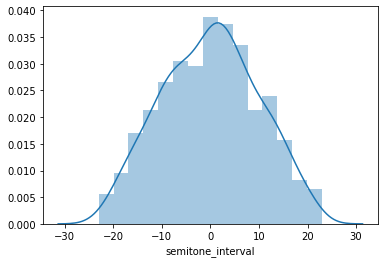

In [27]:
def extract_semitone_interval(data):
    data['semitone_interval']=data.apply(lambda row: np.around(1200*np.log2(abs(row.pitch/row.pitch_previous))/100),
                           axis=1)
    return data

weight_data='treadmill_1_21_06_15_10_04_weight.csv'
weight_data = pd.read_csv('data/'+weight_data)
weight_data[cols] = weight_data[cols].apply(pd.to_numeric)
left_weight,left_zero,right_weight,right_zero = extract_weight(weight_data)

treadmill_data='treadmill_participant_1_order_1_21_06_15_10_04_data.csv'
cols = ['time','x_left','y_left','z_left','x_right','y_right','z_right']
treadmill_data = pd.read_csv('data/'+treadmill_data)
treadmill_data[cols] = treadmill_data[cols].apply(pd.to_numeric)

norm_df = normalize_by_weight(treadmill_data,left_weight,left_zero,right_weight,right_zero)
rs_treadmill_data = resample_all_cols(norm_df)
de_treadmill_data = detrend_all_cols(rs_treadmill_data)
step_data = convert_to_steps(de_treadmill_data)

sound_data='treadmill_participant_1_order_1_21_06_15_10_04_sound.csv'
sound_data = pd.read_csv('data/'+sound_data)
sound_data.pitch = sound_data.pitch.apply(pd.to_numeric)
merged_data = merge_step_data_with_sounds(step_data,sound_data)

data = extract_maximum_amplitude(merged_data)  
data = merge_with_previous_step(merged_data)
data = extract_differences(data)
data = extract_semitone_interval(data)

sns.distplot(data.semitone_interval)

### All processing in one function

In [28]:
def process_data(treadmill_data, weight_data, sound_data, config_data, verbose = True): 
   
    # load data and convert to numeric
    if verbose: 
        print('load,',end='')
    
    cols = ['time','x_left','y_left','z_left','x_right','y_right','z_right']
    weight_data = pd.read_csv(weight_data)
    weight_data[cols] = weight_data[cols].apply(pd.to_numeric)
    
    treadmill_data = pd.read_csv(treadmill_data)
    treadmill_data[cols] = treadmill_data[cols].apply(pd.to_numeric)
    
    sound_data = pd.read_csv(sound_data)
    sound_data.pitch = sound_data.pitch.apply(pd.to_numeric)
    
    
    if verbose: 
        print('preprocess,',end='')
    left_weight,left_zero,right_weight,right_zero = extract_weight(weight_data)
    norm_treadmill_data = normalize_by_weight(treadmill_data,left_weight,left_zero,right_weight,right_zero)
    rs_treadmill_data = resample_all_cols(norm_treadmill_data)
    de_treadmill_data = detrend_all_cols(rs_treadmill_data)
    
    # segment and merge
    if verbose: 
        print('segment,',end='')
    step_data = convert_to_steps(de_treadmill_data)

    if verbose: 
        print('merge,',end='')
    data = merge_step_data_with_sounds(step_data,sound_data)
    
    # delete steps for which there is ambiguity of which sound they correspond to
    data.drop_duplicates(subset ="sound_id", keep = False, inplace=True) 
    
    # extract features
    if verbose: 
        print('extract features',end='')
    extract_step_duration(data)
    extract_maximum_amplitude(data)
        
    # add information from previous_step
    data = merge_with_previous_step(data)
    extract_differences(data)
    extract_semitone_interval(data)
    
    return data


data_t = process_data(treadmill_data='data/treadmill_participant_1_order_1_21_06_15_10_04_data.csv',
                     weight_data='data/treadmill_1_21_06_15_10_04_weight.csv',
                     sound_data='data/treadmill_participant_1_order_1_21_06_15_10_04_sound.csv',
                     config_data='data/treadmill_participant_1_order_1_21_06_15_10_04_config_sound_player_cont_narrow.py')


load,preprocess,segment,merge,extract features

## Statistical Analysis

### Load and process all participant data

List all sessions (participant, block) in data directory, and link with all needed files

In [31]:
# organize files per participants
def parse_participant(file): 
    return int(file.split('_')[2])

def parse_block(file): 
    return int(file.split('_')[4])

def parse_date(file): 
    return datetime.strptime('-'.join(file.split('_')[5:10]), '%d-%m-%y-%H-%M').strftime('%d/%m/%Y')

def find_sound_file(participant,block): 
    files = glob.glob('data/treadmill_participant_%d_order_%d_*_sound.csv'%(participant,block))
    return files[0]

def find_weight_file(participant): 
    files = glob.glob('data/treadmill_participant_%d_*_weight.csv'%(participant))
    return files[0]

def find_config_file(participant,block): 
    files = glob.glob('data/treadmill_participant_%d_order_%d_*_config_*.py'%(participant,block))
    return files[0]

# list sessions {participant id, block, date} from data_files
data_files = glob.glob('data/*_data.csv')
sessions = []
for file_index,data_file in enumerate(data_files):
    
    session = {'participant':parse_participant(data_file),
               'block':parse_block(data_file),
               'date':parse_date(data_file),
               'data':data_file}
    
    # add corresponding sound file
    session['sounds']=find_sound_file(session['participant'],session['block'])
    # add weights
    session['weights']=find_weight_file(session['participant'])
    # add config file and parameters
    session['config']=find_config_file(session['participant'],session['block'])
     
    sessions.append(session)

sessions_df = pd.DataFrame(sessions)

Process files from each session

In [32]:
all_session_data = []
for index, session in sessions_df.iterrows():

    print('Participant %d, block %d: '%(session['participant'],session['block']), end='')
    # process session data into dataframe of trials
    session_data_df = process_data(treadmill_data = session['data'],
                                   weight_data = session['weights'],
                                   sound_data = session['sounds'],
                                   config_data = session['config'],
                                   verbose=False)
    print('%d trials'%len(session_data_df))
    all_session_data.append(session_data_df)

data = pd.concat(all_session_data)


Participant 1, block 1: 749 trials
Participant 1, block 2: 749 trials
Participant 1, block 3: 749 trials
Participant 1, block 4: 749 trials
Participant 2, block 1: 511 trials
Participant 2, block 2: 589 trials
Participant 2, block 3: 697 trials
Participant 2, block 4: 734 trials
Participant 3, block 1: 735 trials
Participant 3, block 2: 731 trials
Participant 3, block 3: 706 trials
Participant 3, block 4: 693 trials
Participant 4, block 1: 749 trials
Participant 4, block 2: 748 trials
Participant 4, block 3: 749 trials
Participant 4, block 4: 748 trials


In [33]:
data.groupby(['participant']).note.count()/4

participant
1    749.00
2    632.75
3    716.25
4    748.50
Name: note, dtype: float64

### Correlation with single note

#### Step #i with note #i

TODO: 
- rather than zscore, do min-max in 0,1
- classifier les diff pitchs en intervalles (avec le nb de cents[centaine]) pour identifier les quintes, tierces,...

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,0.888689,0.001852,479.761592,0.000000,0.00564,0.004963,0.885055,0.892322
1,diff_log_pitch,-0.009560,0.003312,-2.886457,0.003953,0.00564,0.004963,-0.016056,-0.003063


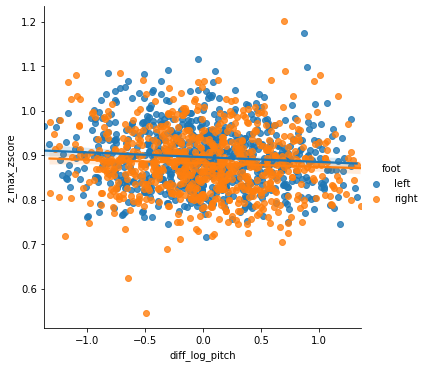

In [482]:
data = data_2
sns.lmplot(data=data,
           x='diff_log_pitch',
           y='z_max_zscore',
           hue='foot')
#plt.ylim([0.85,0.92])
#plt.xscale('log')



pg.linear_regression(data.diff_log_pitch, data.z_max_zscore,remove_na=True)


#### Correlation with pitch and step duration

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,1.053590,0.014978,70.340421,0.000000,0.000136,-0.000542,1.024209,1.082971
1,log_pitch,0.001208,0.002699,0.447676,0.654453,0.000136,-0.000542,-0.004085,0.006501


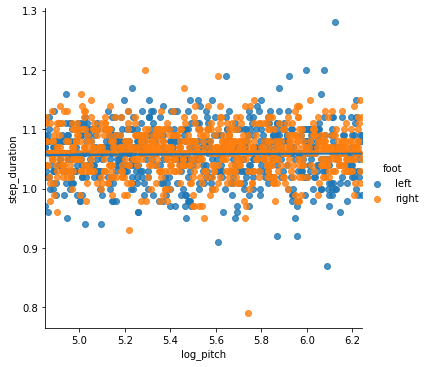

In [19]:
sns.lmplot(data=data,
           x='log_pitch',
           y='step_duration',
           hue='foot')
#plt.ylim([0.85,0.92])
#plt.xscale('log')

pg.linear_regression(data.log_pitch, data.step_duration)

### Correlation with difference between successive notes

#### Correlation with pitch difference and max amplitude

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,0.888689,0.001852,479.761592,0.000000,0.00564,0.004963,0.885055,0.892322
1,diff_log_pitch,-0.009560,0.003312,-2.886457,0.003953,0.00564,0.004963,-0.016056,-0.003063


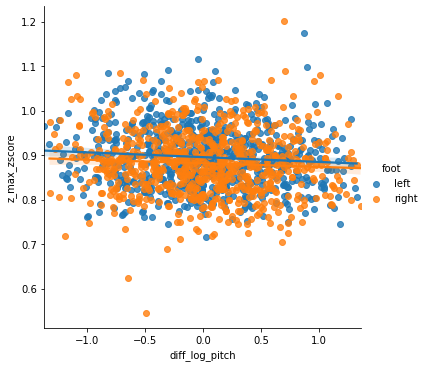

In [484]:
data = data_2
sns.lmplot(data=data,
           x='diff_log_pitch',
           y='z_max_zscore',
           hue='foot')
#plt.ylim([0.85,1.2])
#plt.xscale('log')

pg.linear_regression(data.diff_log_pitch, data.z_max_zscore, remove_na=True)


#### Correlation with pitch difference and max amplitude difference

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,-0.000125,0.002592,-0.048265,0.961511,0.009018,0.008343,-0.005210,0.004960
1,diff_log_pitch,-0.016946,0.004635,-3.656128,0.000265,0.009018,0.008343,-0.026037,-0.007854


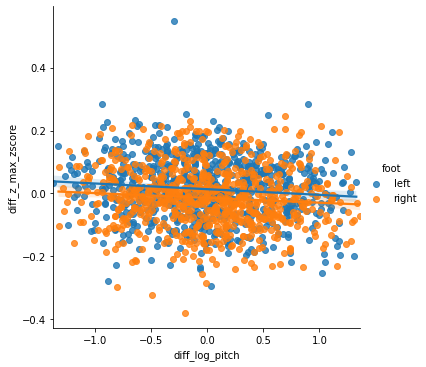

In [486]:
data = data_2
sns.lmplot(data=data,
           x='diff_log_pitch',
           y='diff_z_max_zscore',
           #col='foot',
          hue='foot')
#plt.ylim([1.6,2])
#plt.xscale('log')

pg.linear_regression(data.diff_log_pitch, data.diff_z_max_zscore,remove_na=True)

0             NaN
1             NaN
2        5.375767
3      -10.715727
4        9.465606
          ...    
1471     5.461078
1472    -7.676440
1473    10.464449
1474    -8.737318
1475    10.781658
Name: diff_z_max_percentage, Length: 1476, dtype: float64

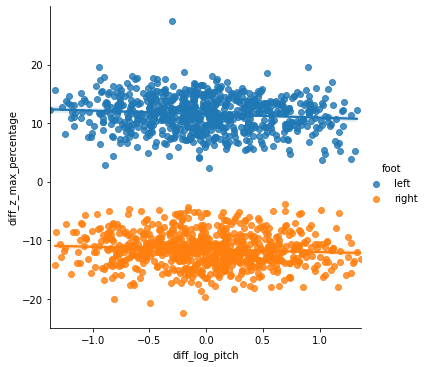

In [494]:
data = data_2
sns.lmplot(data=data,
           x='diff_log_pitch',
           y='diff_z_max_percentage',
           #col='foot',
          hue='foot')
#plt.ylim([1.6,2])
#plt.xscale('log')

pg.linear_regression(data[data.foot=='left'].diff_log_pitch, data[data.foot=='left'].diff_z_max_percentage,remove_na=True)
data.diff_z_max_percentage

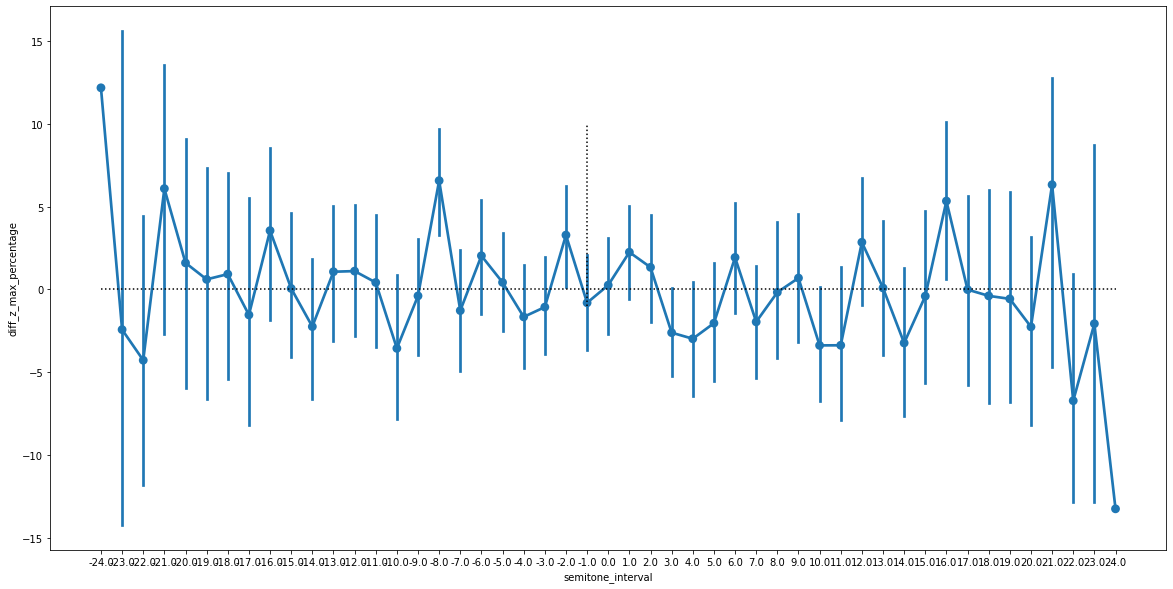

In [495]:
fig = plt.figure(figsize=(20,10))
data = data_2
sns.pointplot(data=data,
           x='semitone_interval',
           y='diff_z_max_percentage')
plt.plot([0,48],[0,0],'k:')
plt.plot([23,23],[-1,10],'k:')


In [211]:
tread_file = "data/treadmill_2_21_05_06_15_02.csv"
sound_file = "data/treadmill_2_21_05_06_15_02_sound.csv"

In [212]:
step=pd.read_csv(tread_file)
sound=pd.read_csv(sound_file)

(110.0, 120.0)

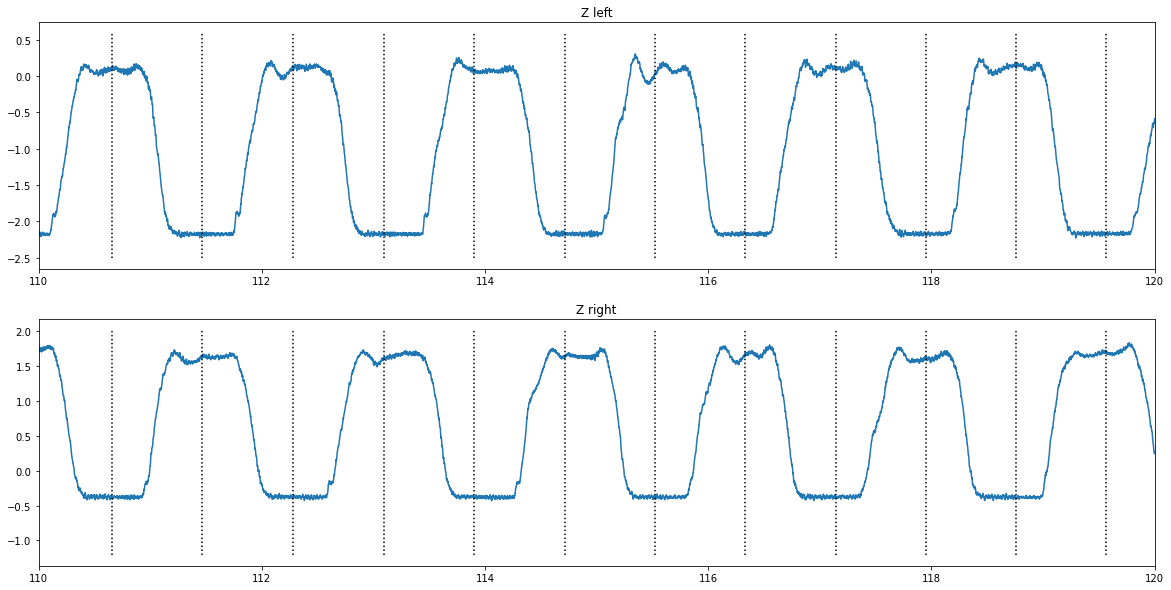

In [213]:
fig = plt.figure(figsize=(20,10))

ax = fig.add_subplot(2,1,1)
plt.plot(step['time']/1000,step['z_left'])
plt.title('Z left')
for id,row in sound.iterrows(): 
    plt.plot([row.time,row.time],[step.z_left.min(),step.z_left.max()],'k:')
plt.xlim([110,120])

ax = fig.add_subplot(2,1,2)
plt.plot(step['time']/1000,step['z_right'])
plt.title('Z right')
for id,row in sound.iterrows(): 
    plt.plot([row.time,row.time],[step.z_right.min(),step.z_right.max()],'k:')
plt.xlim([110,120])

